# The $SO(3)$ case with good quantum number
This notebook will go through the $SO(3)$ case from MPO-MPS to DMRG finally to central charge fitting. 

## The Hamiltonian and basis

The BBQ Hamiltonian is given by

$$
H_{b b}=\sum_i\left[J \sum_{a<b} L_i^{a b} L_{i+1}^{a b}+K\left(\sum_{a<b} L_i^{a b} L_{i+1}^{a b}\right)^2\right]
$$

For $n=3$, one can set $\mathbf{L}^{12} = -S^z$, $\mathbf{L}^{13} = S^y$, and $\mathbf{L}^{23} = -S^x$ to obtain 

$$
H_{SO(3)} = \sum_{i=1}^L \left[J \mathbf{S}_i\cdot\mathbf{S}_{i+1}+K\left( \mathbf{S}_i\cdot\mathbf{S}_{i+1}\right)^2\right],
$$

The natural set of basis is defined by spin: $\ket{1}$, $\ket{0}$ and $\ket{-1}$. The $SO(3)$-symmetric basis is defined by

$$
\ket{x} = \frac{1}{\sqrt{2}}(\ket{-1}-\ket{1}), \quad a_x^\dagger = \frac{1}{\sqrt{2}}(a_{-1}^\dagger-a_{1}^\dagger)
$$
$$
\ket{y} = \frac{\mathrm{i}}{\sqrt{2}}(\ket{-1}+\ket{1}), \quad a_y^\dagger = \frac{\mathrm{i}}{\sqrt{2}}(a_{-1}^\dagger+a_{1}^\dagger)
$$
$$
\ket{z} = \ket{0}, \quad a_z^\dagger = a_0^\dagger
$$

Under the natural basis representation, the matrix form these three generators are:
$$
\mathbf{L}^{12} = -S^z = L^0=-\left(\begin{array}{ccc}
1 & 0 & 0 \\
0 & 0 & 0  \\
0 & 0 & -1  \\
\end{array}\right),
$$

$$
\mathbf{L}^{13} = S^y = L^1=\frac{\mathrm{i}}{\sqrt{2}}\left(\begin{array}{ccc}
0 & -1 & 0 \\
1 & 0 & -1  \\
0 & 1 & 0  \\
\end{array}\right),
$$

$$
\mathbf{L}^{23} = -S^x = L^2=-\frac{1}{\sqrt{2}}\left(\begin{array}{ccc}
0 & 1 & 0 \\
1 & 0 & 1  \\
0 & 1 & 0  \\
\end{array}\right),
$$

Next we gon' write out all the $L$ operators under this natural representation and then we can apply DMRG. There will be finally $n^2 = 3^2 = 9$ operators to represent both the bilinear and biquadratic terms. 

In [16]:
import numpy as np
import numpy.linalg as LA

def get_so3_opr_list():
    L1 = np.array([[-1, 0, 0], [0, 0, 0], [0, 0, 1]])
    L2 = (1j/np.sqrt(2))*np.array([[0, -1, 0], [1, 0, -1], [0, 1, 0]])
    L3 = -(1/np.sqrt(2))*np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
    
    Loprs = [L1, L2, L3]
    coe_list = []
    
    for a in range(len(Loprs)):
        for b in range(len(Loprs)):
            LiLi = np.dot(Loprs[a], Loprs[b])
            Amat = np.zeros((9, len(Loprs)), dtype=complex)
            B = LiLi.reshape(-1,1)
            for l in range(len(Loprs)):
                Amat[:,l] = Loprs[l].reshape(-1,1)[:,0]
            pcoe, resi, rank, sing = LA.lstsq(Amat, B, rcond=None)
            if len(resi)!=0 and resi[0]>1e-10:
                Loprs.append(LiLi)
                pcoe = np.append(np.zeros((len(Loprs)-1, 1)),1).reshape(len(Loprs),1)
                coe_list.append(pcoe)
            else:
                coe_list.append(pcoe)
                
    coe_list_new = []
    for a in range(len(Loprs)):
        for b in range(len(Loprs)):
            LiLi = Loprs[a] @ Loprs[b]
            Amat = np.zeros((9, len(Loprs)), dtype=complex)
            B = LiLi.reshape(-1,1)
            for l in range(len(Loprs)):
                Amat[:,l] = Loprs[l].reshape(-1,1)[:,0]
            pcoe = LA.solve(Amat, B)
            coe_list_new.append(pcoe)
            
    coe_list = coe_list_new

    for i in range(len(coe_list)):
        coe_list[i] = coe_list[i].reshape(9)

    def pvec(a,b):
        return coe_list[len(Loprs)*a+b] #a,b=0,1,2,3
    
    cmn = np.zeros((9,9), dtype=complex)

    P = dict()
    for a in range(len(Loprs)):
        for b in range(len(Loprs)):
            P[(a,b)] = pvec(a,b)
    
    for m in range(9):
        for n in range(9):
            for a in range(len(Loprs)):
                for b in range(len(Loprs)):
                    cmn[m,n] += P[(a,b)][m] * P[(a,b)][n]

    return Loprs, cmn

In [17]:
L_operators, c_mn = get_so3_opr_list()

for i in range(len(L_operators)):
    print("the", i, "th operator is")
    print(L_operators[i])
    print('')

the 0 th operator is
[[-1  0  0]
 [ 0  0  0]
 [ 0  0  1]]

the 1 th operator is
[[ 0.+0.j         -0.-0.70710678j  0.+0.j        ]
 [ 0.+0.70710678j  0.+0.j         -0.-0.70710678j]
 [ 0.+0.j          0.+0.70710678j  0.+0.j        ]]

the 2 th operator is
[[-0.         -0.70710678 -0.        ]
 [-0.70710678 -0.         -0.70710678]
 [-0.         -0.70710678 -0.        ]]

the 3 th operator is
[[1 0 0]
 [0 0 0]
 [0 0 1]]

the 4 th operator is
[[0.+0.j         0.+0.70710678j 0.+0.j        ]
 [0.+0.j         0.+0.j         0.+0.j        ]
 [0.+0.j         0.+0.70710678j 0.+0.j        ]]

the 5 th operator is
[[ 0.          0.70710678  0.        ]
 [ 0.          0.          0.        ]
 [ 0.         -0.70710678  0.        ]]

the 6 th operator is
[[ 0.5+0.j  0. +0.j -0.5+0.j]
 [ 0. +0.j  1. +0.j  0. +0.j]
 [-0.5+0.j  0. +0.j  0.5+0.j]]

the 7 th operator is
[[0.+0.5j 0.+0.j  0.+0.5j]
 [0.+0.j  0.+0.j  0.+0.j ]
 [0.-0.5j 0.+0.j  0.-0.5j]]

the 8 th operator is
[[0.+0.j 0.+0.j 0.+0.j]
 [0.+0

Here are 9 on-site operators now, they are

$$
L^0=\left(\begin{array}{ccc}
-1 & 0 & 0 \\
0 & 0 & 0  \\
0 & 0 & 1  \\
\end{array}\right), \quad L^1=\frac{\mathrm{i}}{\sqrt{2}}\left(\begin{array}{ccc}
0 & -1 & 0 \\
1 & 0 & -1  \\
0 & 1 & 0  \\
\end{array}\right), \quad L^2=\frac{1}{\sqrt{2}}\left(\begin{array}{ccc}
0 & -1 & 0 \\
-1 & 0 & -1  \\
0 & -1 & 0  \\
\end{array}\right),
$$

$$
L^3=\left(\begin{array}{ccc}
1 & 0 & 0 \\
0 & 0 & 0  \\
0 & 0 & 1  \\
\end{array}\right), \quad L^4=\frac{\mathrm{i}}{\sqrt{2}}\left(\begin{array}{ccc}
0 & 1 & 0 \\
0 & 0 & 0  \\
0 & 1 & 0  \\
\end{array}\right), \quad L^5=\frac{1}{\sqrt{2}}\left(\begin{array}{ccc}
0 & 1 & 0 \\
0 & 0 & 0  \\
0 & -1 & 0  \\
\end{array}\right),
$$

$$
L^6=\frac{1}{2}\left(\begin{array}{ccc}
1 & 0 & -1 \\
0 & 2 & 0  \\
-1 & 0 & 1  \\
\end{array}\right), \quad L^7=\frac{\mathrm{i}}{2}\left(\begin{array}{ccc}
1 & 0 & 1 \\
0 & 0 & 0  \\
-1 & 0 & -1  \\
\end{array}\right), \quad L^8=\mathrm{i}\left(\begin{array}{ccc}
0 & 0 & 0 \\
0 & 1 & 0  \\
0 & 0 & 0  \\
\end{array}\right),
$$

The $U(1)$ good quantum number show up in $L^0$, then we define the leg charges as 

```chinfo = npc.ChargeInfo([1], ['S'])```

```leg = npc.LegCharge.from_qflat(chinfo, [[-1], [0], [1]])```

With this leg, the $3\times 3$ matrix form of any operator hold the $U(1)$ symmetry should have total quantum numbers below

$$
\begin{array}{|c|c|c|}
\hline 0  & -1 & -2   \\
\hline 1 & 0 & -1  \\
\hline 2 & 1 & 0   \\
\hline
\end{array}
$$

Thus we need to do some linear combinations in order to make the $L$ matrices fit in the leg charges. 

In [18]:
print((-1/2)*(-(1j*np.sqrt(2)) * L_operators[1] + np.sqrt(2) * L_operators[2]))
print((1/2)*(-(1j*np.sqrt(2)) * L_operators[1] - np.sqrt(2) * L_operators[2]))

print((1/2)*(-(1j*np.sqrt(2)) * L_operators[4] + np.sqrt(2) * L_operators[5]))
print((1/2)*(-(1j*np.sqrt(2)) * L_operators[4] - np.sqrt(2) * L_operators[5]))

[[-0.+0.j  1.-0.j -0.+0.j]
 [-0.+0.j -0.+0.j  1.-0.j]
 [-0.+0.j -0.+0.j -0.+0.j]]
[[0.+0.j 0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j]]
[[0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j]]
[[0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j]]


In [19]:
print(2*L_operators[6])
print(2j*L_operators[7])

print(2*L_operators[6] + 2j*L_operators[7] + 2j*L_operators[8])

[[ 1.+0.j  0.+0.j -1.+0.j]
 [ 0.+0.j  2.+0.j  0.+0.j]
 [-1.+0.j  0.+0.j  1.+0.j]]
[[-1.+0.j  0.+0.j -1.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j]
 [ 1.+0.j  0.+0.j  1.+0.j]]
[[ 0.+0.j  0.+0.j -2.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  2.+0.j]]


$$
\hat{L}^0=\left(\begin{array}{ccc}
-1 & 0 & 0 \\
0 & 0 & 0  \\
0 & 0 & 1  \\
\end{array}\right), \quad \hat{L}^1=\left(\begin{array}{ccc}
0 & 1 & 0 \\
0 & 0 & 1  \\
0 & 0 & 0  \\
\end{array}\right), \quad \hat{L}^2=\left(\begin{array}{ccc}
0 & 0 & 0 \\
1 & 0 & 0  \\
0 & 1 & 0  \\
\end{array}\right),
$$

$$
\hat{L}^3=\left(\begin{array}{ccc}
1 & 0 & 0 \\
0 & 0 & 0  \\
0 & 0 & 1  \\
\end{array}\right), \quad \hat{L}^4=\left(\begin{array}{ccc}
0 & 1 & 0 \\
0 & 0 & 0  \\
0 & 0 & 0  \\
\end{array}\right), \quad \hat{L}^5=\left(\begin{array}{ccc}
0 & 0 & 0 \\
0 & 0 & 0  \\
0 & 1 & 0  \\
\end{array}\right),
$$

$$
\hat{L}^6=\left(\begin{array}{ccc}
0 & 0 & 1 \\
0 & 0 & 0  \\
0 & 0 & 0  \\
\end{array}\right), \quad \hat{L}^7=\left(\begin{array}{ccc}
0 & 0 & 0 \\
0 & 0 & 0  \\
1 & 0 & 0  \\
\end{array}\right), \quad \hat{L}^8=\left(\begin{array}{ccc}
0 & 0 & 0 \\
0 & 1 & 0  \\
0 & 0 & 0  \\
\end{array}\right),
$$

Now we should make the biquadratic terms represented by the new hatted 16 on-site operators. That is the expansion

$$
\left(\sum_{a,b=1}^6 L^a(i) \otimes L^b(i+1)\right) = \sum_{m,n=0}^{9} c_{mn} \hat{L}^m(i)\otimes \hat{L}^n(i+1)
$$

That is to say, we should get this decomposition done again
$$
L^a(i)L^b(i) = \sum_{m=0}^{9} p_m(a,b) \hat{L}^m(i)
$$

Then we will have
$$
L^a(i)L^b(i) \otimes L^a(i+1)L^b(i+1) = \sum_{m=0}^{9}\sum_{n=0}^{9} p_m(a,b)p_n(a,b) \hat{L}^m(i) \otimes \hat{L}^n(i+1)
$$

By defining 
$$
c_{mn} = \sum_{a,b=1}^4 p_m(a,b) p_n(a,b), 
$$
everything follow the $SO(6)$ case again. 

(20241003) Notice that the bilinear terms are different from the SO(6) case since we have changed the whole basis. 

$$
\begin{aligned}
H_{\mathrm{bilinear}} &= \sum_{i=1}^N J \sum_{a=1}^4 L^a(i)\otimes L^a(i+1) \\
&= \sum_{i=1}^N J \sum_{a=1}^4 \left(\sum_{m=0}^{9} q_m(a)\hat{L}^m(i) \otimes \sum_{n=0}^{9} q_n(a)\hat{L}^n(i+1) \right) \\
&= \sum_{i=1}^N J \sum_{m,n=0}^{9} \sum_{a=1}^4 q_m(a) q_n(a) \hat{L}^m(i) \hat{L}^n(i+1) \\
&= \sum_{i=1}^N J \sum_{m,n=0}^{9} d_{mn} \hat{L}^m(i) \hat{L}^n(i+1)
\end{aligned}
$$

In [20]:
def get_so3_opr_list_new():
    L1 = np.array([[-1, 0, 0], [0, 0, 0], [0, 0, 1]])
    L2 = (1j/np.sqrt(2))*np.array([[0, -1, 0], [1, 0, -1], [0, 1, 0]])
    L3 = -(1/np.sqrt(2))*np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
    
    Loprs = [L1, L2, L3]
    Lhatoprs = [
        np.array([
            [-1, 0, 0],
            [0, 0, 0],
            [0, 0, 1]
        ]),
        np.array([
            [0, 1, 0],
            [0, 0, 1],
            [0, 0, 0]
        ]),
        np.array([
            [0, 0, 0],
            [1, 0, 0],
            [0, 1, 0]
        ]),
        np.array([
            [1, 0, 0],
            [0, 0, 0],
            [0, 0, 1]
        ]),
        np.array([
            [0, 1, 0],
            [0, 0, 0],
            [0, 0, 0]
        ]),
        np.array([
            [0, 0, 0],
            [0, 0, 0],
            [0, 1, 0]
        ]),
        np.array([
            [0, 0, 1],
            [0, 0, 0],
            [0, 0, 0]
        ]),
        np.array([
            [0, 0, 0],
            [0, 0, 0],
            [1, 0, 0]
        ]),
        np.array([
            [0, 0, 0],
            [0, 1, 0],
            [0, 0, 0]
        ]),
    ]

    coe_list = []

    for a in range(len(Loprs)):
        for b in range(len(Loprs)):
            LiLi = Loprs[a] @ Loprs[b]
            Amat = np.zeros((9, len(Lhatoprs)), dtype=complex)
            B = LiLi.reshape(-1,1)
            for l in range(len(Lhatoprs)):
                Amat[:,l] = Lhatoprs[l].reshape(-1,1)[:,0]
            pcoe = LA.solve(Amat, B)
            coe_list.append(pcoe)

    for i in range(len(coe_list)):
        coe_list[i] = coe_list[i].reshape(9)

    def pvec(a,b):
        return coe_list[len(Loprs)*a+b] #a,b=0,1,2,3
    
    cmn = np.zeros((9,9), dtype=complex)

    P = dict()
    for a in range(len(Loprs)):
        for b in range(len(Loprs)):
            P[(a,b)] = pvec(a,b)
    
    for m in range(9):
        for n in range(9):
            for a in range(len(Loprs)):
                for b in range(len(Loprs)):
                    cmn[m,n] += P[(a,b)][m] * P[(a,b)][n]

    coe_list_new = []
    for a in range(len(Loprs)):
        Li = Loprs[a]
        Amat = np.zeros((9, len(Lhatoprs)), dtype=complex)
        B = Li.reshape(-1,1)
        for l in range(len(Lhatoprs)):
            Amat[:,l] = Lhatoprs[l].reshape(-1,1)[:,0]
        qcoe = LA.solve(Amat, B)
        coe_list_new.append(qcoe)
    
    for i in range(len(coe_list_new)):
        coe_list_new[i] = coe_list_new[i].reshape(9)

    def qvec(a):
        return coe_list_new[a]
    
    dmn = np.zeros((9,9), dtype=complex)
    
    Q = dict()
    for a in range(len(Loprs)):
        Q[a] = qvec(a)

    for m in range(9):
        for n in range(9):
            for a in range(len(Loprs)):
                dmn[m,n] += Q[a][m] * Q[a][n]

    return Lhatoprs, cmn, dmn

In [21]:
from tenpy.models.model import CouplingModel, MPOModel
from tenpy.networks.site import SpinSite, FermionSite, Site
from tenpy.models.lattice import Chain
from tenpy.networks.mps import MPS
from tenpy.networks.mpo import MPO
import tenpy.linalg.np_conserved as npc
from tenpy.linalg.charges import LegCharge, ChargeInfo
from tenpy.algorithms import dmrg
from tenpy.tools.params import asConfig

In [22]:
class SO3Site(Site):
    def __init__(self, so4g, cons_N=None, cons_S=None):
        self.conserve = [cons_N, cons_S]
        self.cons_N = cons_N
        self.cons_S = cons_S
        self.so4g = so4g
        
        if self.cons_N is None and self.cons_S == 'U1':
            chinfo = npc.ChargeInfo([1], ['S'])
            leg = npc.LegCharge.from_qflat(chinfo, [[-1], [0], [1]])
        elif self.cons_N is None and self.cons_S is None:
            leg = npc.LegCharge.from_trivial(3)
        
        ops = dict()
        for i in range(len(self.so4g)):
            ops['L{}'.format(i)] = self.so4g[i]

        names = ['d', 'z', 'u']
        Site.__init__(self, leg, names, **ops)

    def __repr__(self):
        return "trivial site for 9 so3 generators"

In [23]:
class BBQJKSO3(CouplingModel):
    def __init__(self, model_params):
        print(model_params)
        model_params = asConfig(model_params, self.__class__.__name__)
        self.model_params = model_params
        self.Lx = model_params.get('Lx', 12)
        self.S = model_params.get('S', 1)
        self.bc = model_params.get('bc', 'periodic')
        self.J = model_params.get('J', 1)
        self.K = model_params.get('K', 1/3)
        self.verbose = model_params.get('verbose', 2)
        self.D = model_params.get('D', 200)
        self.sweeps = model_params.get('sweeps', 10)
        self.conn = model_params.get('conn', None)
        self.cons = model_params.get('cons', 'U1')
        
        self.so4_generators, self.c_mn, self.d_mn = get_so3_opr_list_new()

        site = SO3Site(self.so4_generators, cons_N=self.conn, cons_S=self.cons)
        self.sites = [site] * self.Lx
        self.lat = Chain(self.Lx, site, bc=self.bc)
        CouplingModel.__init__(self, self.lat, explicit_plus_hc=False)
        self.init_terms(model_params)
        H_MPO = self.calc_H_MPO()
        if model_params.get('sort_mpo_legs', False):
            H_MPO.sort_legcharges()
        MPOModel.__init__(self, self.lat, H_MPO)
        model_params.warn_unused()

    def init_terms(self, model_params):
        J = model_params.get("J", 1.)
        K = model_params.get('K', 1/3)
        for l in range(self.Lx):
            if l < self.Lx - 1:
                i0, i1 = l, (l+1)%self.Lx
            elif l == self.Lx-1 and self.bc == 'periodic':
                i0, i1 = 0, self.Lx-1
                print("periodic terms added")
            else:
                break
        
            for m in range(9):
                for n in range(9):
                    self.add_coupling_term(J*np.round(self.d_mn[m,n],6), i0, i1, "L"+str(m), "L"+str(n))
                    if K != 0:
                        self.add_coupling_term(K*np.round(self.c_mn[m,n],6), i0, i1, "L"+str(m), "L"+str(n))
    
    def run_dmrg(self, **kwargs):
        mixer      = kwargs.get('mixer', True)
        chi_max    = kwargs.get('chi_max', self.D)
        max_E_err  = kwargs.get('max_E_err', 1e-10)
        max_sweeps = kwargs.get('max_sweeps', self.sweeps)
        min_sweeps = kwargs.get('min_sweeps', min(4, max_sweeps) )
        dmrg_params = dict(mixer=mixer, 
                           trunc_params=dict(chi_max=chi_max),
                           max_E_err=max_E_err, 
                           max_sweeps=max_sweeps,
                           min_sweeps=min_sweeps,
                           verbose=2)

        init = kwargs.get('init', None)
        if init is None:
            N = self.lat.N_sites
            if N%6==0 and N>0:
                init = [0]*(N//3) + [1]*(N//3) + [2]*(N//3)
            else:
                raise("Check the system size must be integral multiple of 6")
            np.random.shuffle(init)
            psiinit = MPS.from_product_state(self.lat.mps_sites(), init)
            psiinit.norm = 1
            psiinit.canonical_form()
        elif isinstance(init, list):
            psiinit = MPS.from_product_state(self.lat.mps_sites(), init)            
        elif isinstance(init, MPS):
            psiinit = init
        else:
            print("wrong init")

        eng = dmrg.TwoSiteDMRGEngine(psiinit, self, dmrg_params)
        E, psidmrg = eng.run()
        print("Eng = ", E)
        self.psidmrg = psidmrg
        return psidmrg, E

In [24]:
import logging
logging.basicConfig(level=2)
for _ in ['parso.python.diff', 'parso.cache', 'parso.python.diff', 
            'parso.cache', 'matplotlib.font_manager', 'tenpy.tools.cache', 
            'tenpy.algorithms.mps_common', 'tenpy.linalg.lanczos', 'tenpy.tools.params']:
    logging.getLogger(_).disabled = True

## MPO-MPS part

In [25]:
import itertools
def adaggermatrix(flavor, basis):
    """
    Calculate matrix form of a_[flavor]^\dagger under [basis]

    Args:
        flavor (str): the flavor of parton, chosen from u,v,w,x,y,z
        basis (list of str): exactly the var [name] defined in Site.__init__, it's 64-dim, ['empty','u','v',...]

    Returns:
        amatrixform (ndarray): the matrix form of a_flavor^\dagger
        
    Notes:
        It's ugly, but it works well. 
    """
    basislength = len(basis) #for SO(4), it's 16
    adaggermatrixform = np.zeros((basislength,basislength))
    for l in range(basislength):
        if basis[l] == 'empty':
            setL = set()
        else:
            setL = set(basis[l])
        for r in range(basislength):
            if basis[r] == 'empty':
                setR = set()
            else:
                setR = set(basis[r])
            
            if (flavor in setL) and (flavor not in setR):
                diff = setL - setR
                listdiff = list(diff)
                
                if len(setL)-len(setR)==1 and len(listdiff) == 1 and listdiff[0] == flavor:
                    adaggermatrixform[l,r] = 1
    return adaggermatrixform

def fmatrix(flavor, basis):
    """
    Calculate the Jordan-Wigner F matrix of a given flavor. Convention is in consist with the one on ITensor doc

    Args:
        flavor (str): the flavor of parton, chosen from u,v,w,x,y,z
        basis (list of str): exactly the var [name] defined in Site.__init__, it's 64-dim, ['empty','u','v',...]
        
    Returns:
        fmat (ndarray): the in-site Jordan-Wigner matrix of the given flavor
    """
    flist = [1]
    for i in range(1,len(basis)):
        if flavor in basis[i]:
            flist.append(-1)
        else:
            flist.append(1)
    fmat = np.diag(flist)
    return fmat

In [26]:
from bdgpack import *
class KitaevSingleChain():
    def __init__(self, chi, delta, lamb, L, bc='open'):
        """
        The Single Kitaev chain class. 
        
        The Hamiltonian is in the BdG form, the matrix is written under the Bogoliubov *QUASIHOLE* representation. 

        Args:
            chi (float): variational parameter $\chi$
            delta (float): variational parameter $\delta$
            lamb (float): variational parameter $\lambda$
            L (int): Chain length
            bc (str, optional): Boundary condition. Defaults to 'open'.
            
        Raises:
            Check bc must be open or periodic: check your boundary condition input
        """
        self.L = L
        self.chi = chi
        self.delta = delta
        self.lamb = lamb
        self.bc = bc
        self.model = "Single Kitaev chain_L{}_chi{}_delta{}_lambda{}_bc{}".format(L, round(chi, 3), round(delta, 3), round(lamb, 3), bc)
        self.dtype = np.float64
        if bc == 'open':
            self.pbc = 0
        elif bc == 'periodic':
            self.pbc = 1
        else:
            raise "Check bc must be open or periodic"
        
    def calc_hamiltonian(self):
        """
        BdG Hamiltonian calculator. 

        As a !type function. Calculate the $t$ and $d$ matrices, the real space Hamiltonian, the $V$ and $U$ matrices and the $M$=[[V,U^*],[U,V^*]] matrix. 
        """
        L = self.L
        t = -self.chi
        d = self.delta
        mu = self.lamb
        self.tmat = np.zeros((L,L), dtype=self.dtype)
        self.dmat = np.zeros((L,L), dtype=self.dtype)
        for i in range(L):
            self.tmat[i, i] = mu/2 
        for i in range(L-1):
            self.tmat[i, (i+1)%L] = t 
            self.dmat[i, (i+1)%L] = d 
        self.parity = 1
        if self.pbc:
            parity = - 1 + 2 * ( L % 2 )
            self.parity = parity
            self.tmat[L-1, 0] = t*parity 
            self.dmat[L-1, 0] = d*parity 
        self.tmat += self.tmat.T.conj() 
        self.dmat -= self.dmat.T
        
        self.ham = np.block([[self.tmat, self.dmat],[-self.dmat.conj(), -self.tmat.conj()]])
        self.eig_eng, self.eig_vec = bdgeig(self.ham)
        print("the eig energies", self.eig_eng)
        self.V, self.U = m2vu(self.eig_vec)
        self.M = vu2m(self.V, self.U)

class threeparton(Site):
    def __init__(self, cons_N=None, cons_S=None):
        self.conserve = [cons_N, cons_S]
        self.cons_N = cons_N
        self.cons_S = cons_S

        flavors = ['x', 'y', 'z']
        
        if cons_N == None and cons_S == 'U1':
            chinfo = npc.ChargeInfo([1], ['S'])
            leg = npc.LegCharge.from_qflat(chinfo, [[0], [-1], [0], [1], [-1], [0], [1], [0]]) #change x->-1 y->0 z->1 here to fit the Cartan subalgebra U(1) GQN !!!!!!!!!!KEY
        else:
            print('No symmetry used in site threeparton')
            leg = npc.LegCharge.from_trivial(8)

        names = ['empty', 'x', 'y', 'z', 'xy', 'xz', 'yz', 'xyz']

        JW = np.diag([1,-1,-1,-1,1,1,1,-1])
        Fx = np.diag([1,-1,1,1,-1,-1,1,-1])
        Fy = np.diag([1,1,-1,1,-1,1,-1,-1])
        id8 = np.diag([1,1,1,1,1,1,1,1])
        
        axdag = np.zeros((8,8))
        axdag[1,0] = 1; axdag[4,2] = 1; axdag[5,3] = 1; axdag[7,6] = 1; 
        ax = axdag.T
        aydag = np.zeros((8,8))
        aydag[2,0] = 1; aydag[4,1] = 1; aydag[6,3] = 1; aydag[7,5] = 1; 
        ay = aydag.T
        azdag = np.zeros((8,8))
        azdag[3,0] = 1; azdag[5,1] = 1; azdag[6,2] = 1; azdag[7,4] = 1; 
        az = azdag.T

        cxdag = axdag
        cx = ax
        cydag = aydag @ Fx
        cy = Fx @ ay
        czdag = azdag @ Fy @ Fx
        cz = Fx @ Fy @ az

        ops = dict(JW=JW, Fx=Fx, Fy=Fy, id8=id8, 
                   cxdag = cxdag, cx = cx, cydag = cydag, cy = cy, czdag = czdag, cz = cz) #with the JW string embedded in c operators, there is no need to add a operators into ops dict. 
        
        Site.__init__(self, leg, names, **ops)

class MPOMPS():
    def __init__(self, v, u, **kwargs):
        self.cons_N = kwargs.get("cons_N", None)
        self.cons_S = kwargs.get("cons_S", 'U1')
        self.trunc_params = kwargs.get("trunc_params", dict(chi_max=20) )

        assert v.ndim == 2
        self._V = v
        self._U = u
        assert self._U.shape == self._V.shape
        self.projection_type = kwargs.get("projection_type", "Gutz")
        #self.L = self.Llat = u.shape[1]//3 #for 3 in 1 site, only 1 Kitaev chain should be calculated
        self.L = self.Llat = u.shape[0] #the length of real sites
        
        self.site = threeparton(self.cons_N, self.cons_S)
        self.init_mps()

    def init_mps(self, init=None):
        L = self.L
        if init == None:
            init = [0] * L #all empty
        site = self.site
        self.init_psi = MPS.from_product_state([site]*L, init)
        self.psi = self.init_psi.copy()
        self.n_omode = 0
        return self.psi
    
    def get_mpo_Z2U1(self, v, u, xyz):
        chinfo = self.site.leg.chinfo
        pleg = self.site.leg #physical leg
        
        if xyz == 1: #v czdag + u cx
            qn = [1]
        elif xyz == 0: #v cydag + u cy
            qn = [0]
        elif xyz == -1: #v cxdag + u cz
            qn = [-1]
        else:
            raise "quantum number of d mode i.e. xyz should be 1,0,-1"
        
        firstleg = npc.LegCharge.from_qflat(chinfo, [[0]], 1)
        lastleg = npc.LegCharge.from_qflat(chinfo, [qn], -1)
        bulkleg = npc.LegCharge.from_qflat(chinfo, [qn, [0]], 1)
        #legs arrange in order 'wL', 'wR', 'p', 'p*'
        legs_first = [firstleg, bulkleg.conj(), pleg, pleg.conj()]
        legs_bulk = [bulkleg, bulkleg.conj(), pleg, pleg.conj()]
        legs_last = [bulkleg, lastleg, pleg, pleg.conj()]
        
        mpo = []
        L = self.L
        
        t0 = npc.zeros(legs_first, labels=['wL', 'wR', 'p', 'p*'], dtype=u.dtype)
        i = 0
        """
        Modify the following part to fit the new SO(3) symmetry
        """
        if xyz == 1:
            # t0[0, 0, 1, 0] = v[0]; t0[0, 0, 4, 2] = v[0]; t0[0, 0, 5, 3] = v[0]; t0[0, 0, 7, 6] = v[0]; #v cxdag
            # t0[0, 0, 0, 2] = u[0]; t0[0, 0, 1, 4] = -u[0]; t0[0, 0, 3, 6] = u[0]; t0[0, 0, 5, 7] = -u[0]; #u F cy
            t0[0, 0, :, :] = v[0]*self.site.get_op('czdag') + u[0]*self.site.get_op('cx')
        elif xyz == 0:
            # t0[0, 0, 3, 0] = v[0]; t0[0, 0, 5, 1] = -v[0]; t0[0, 0, 6, 2] = -v[0]; t0[0, 0, 7, 4] = v[0]; #v czdag F
            # t0[0, 0, 0, 3] = u[0]; t0[0, 0, 1, 5] = -u[0]; t0[0, 0, 2, 6] = -u[0]; t0[0, 0, 4, 7] = u[0]; #u F cz
            t0[0, 0, :, :] = v[0]*self.site.get_op('cydag') + u[0]*self.site.get_op('cy')
        elif xyz == -1:
            # t0[0, 0, 2, 0] = v[0]; t0[0, 0, 4, 1] = -v[0]; t0[0, 0, 6, 3] = v[0]; t0[0, 0, 7, 5] = -v[0]; #v cydag F
            # t0[0, 0, 0, 1] = u[0]; t0[0, 0, 2, 4] = u[0]; t0[0, 0, 3, 5] = u[0]; t0[0, 0, 6, 7] = u[0]; #u cx
            t0[0, 0, :, :] = v[0]*self.site.get_op('cxdag') + u[0]*self.site.get_op('cz')
            
        t0[0, 1, 0, 0] = 1; t0[0, 1, 1, 1] = -1; t0[0, 1, 2, 2] = -1; t0[0, 1, 3, 3] = -1; 
        t0[0, 1, 4, 4] = 1; t0[0, 1, 5, 5] = 1; t0[0, 1, 6, 6] = 1; t0[0, 1, 7, 7] = -1; 
        mpo.append(t0)
        
        for i in range(1,L-1):
            ti = npc.zeros(legs_bulk, labels=['wL', 'wR', 'p', 'p*'], dtype=u.dtype)
            ti[0,0,0,0] = 1; ti[0,0,1,1] = 1; ti[0,0,2,2] = 1; ti[0,0,3,3] = 1; 
            ti[0,0,4,4] = 1; ti[0,0,5,5] = 1; ti[0,0,6,6] = 1; ti[0,0,7,7] = 1; 
            if xyz == 1:
                # ti[1, 0, 1, 0] = v[i]; ti[1, 0, 4, 2] = v[i]; ti[1, 0, 5, 3] = v[i]; ti[1, 0, 7, 6] = v[i]; 
                # ti[1, 0, 0, 2] = u[i]; ti[1, 0, 1, 4] = -u[i]; ti[1, 0, 3, 6] = u[i]; ti[1, 0, 5, 7] = -u[i]; 
                ti[1, 0, :, :] = v[i]*self.site.get_op('czdag') + u[i]*self.site.get_op('cx')
            elif xyz == 0:
                # ti[1, 0, 3, 0] = v[i]; ti[1, 0, 5, 1] = -v[i]; ti[1, 0, 6, 2] = -v[i]; ti[1, 0, 7, 4] = v[i]; 
                # ti[1, 0, 0, 3] = u[i]; ti[1, 0, 1, 5] = -u[i]; ti[1, 0, 2, 6] = -u[i]; ti[1, 0, 4, 7] = u[i]; 
                ti[1, 0, :, :] = v[i]*self.site.get_op('cydag') + u[i]*self.site.get_op('cy')
            elif xyz == -1:
                # ti[1, 0, 2, 0] = v[i]; ti[1, 0, 4, 1] = -v[i]; ti[1, 0, 6, 3] = v[i]; ti[1, 0, 7, 5] = -v[i]; 
                # ti[1, 0, 0, 1] = u[i]; ti[1, 0, 2, 4] = u[i]; ti[1, 0, 3, 5] = u[i]; ti[1, 0, 6, 7] = u[i]; 
                ti[1, 0, :, :] = v[i]*self.site.get_op('cxdag') + u[i]*self.site.get_op('cz')
            ti[1, 1, 0, 0] = 1; ti[1, 1, 1, 1] = -1; ti[1, 1, 2, 2] = -1; ti[1, 1, 3, 3] = -1; 
            ti[1, 1, 4, 4] = 1; ti[1, 1, 5, 5] = 1; ti[1, 1, 6, 6] = 1; ti[1, 1, 7, 7] = -1; 
            mpo.append(ti)
                
        i = L-1
        tL = npc.zeros(legs_last, labels=['wL', 'wR', 'p', 'p*'], dtype=u.dtype)
        tL[0,0,0,0] = 1; tL[0,0,1,1] = 1; tL[0,0,2,2] = 1; tL[0,0,3,3] = 1; 
        tL[0,0,4,4] = 1; tL[0,0,5,5] = 1; tL[0,0,6,6] = 1; tL[0,0,7,7] = 1; 
        if xyz == 1:
            # tL[1, 0, 1, 0] = v[i]; tL[1, 0, 4, 2] = v[i]; tL[1, 0, 5, 3] = v[i]; tL[1, 0, 7, 6] = v[i]; 
            # tL[1, 0, 0, 2] = u[i]; tL[1, 0, 1, 4] = -u[i]; tL[1, 0, 3, 6] = u[i]; tL[1, 0, 5, 7] = -u[i]; 
            tL[1, 0, :, :] = v[i]*self.site.get_op('czdag') + u[i]*self.site.get_op('cx')
        elif xyz == 0:
            # tL[1, 0, 3, 0] = v[i]; tL[1, 0, 5, 1] = -v[i]; tL[1, 0, 6, 2] = -v[i]; tL[1, 0, 7, 4] = v[i]; 
            # tL[1, 0, 0, 3] = u[i]; tL[1, 0, 1, 5] = -u[i]; tL[1, 0, 2, 6] = -u[i]; tL[1, 0, 4, 7] = u[i]; 
            tL[1, 0, :, :] = v[i]*self.site.get_op('cydag') + u[i]*self.site.get_op('cy')
        elif xyz == -1:
            # tL[1, 0, 2, 0] = v[i]; tL[1, 0, 4, 1] = -v[i]; tL[1, 0, 6, 3] = v[i]; tL[1, 0, 7, 5] = -v[i]; 
            # tL[1, 0, 0, 1] = u[i]; tL[1, 0, 2, 4] = u[i]; tL[1, 0, 3, 5] = u[i]; tL[1, 0, 6, 7] = u[i]; 
            tL[1, 0, :, :] = v[i]*self.site.get_op('cxdag') + u[i]*self.site.get_op('cz')
        mpo.append(tL)
        
        return mpo
    
    def mpomps_step_1time(self, m, xyz):
        vm = self._V[:,m]
        um = self._U[:,m]
        mps = self.psi
        if self.cons_N==None and self.cons_S=='U1':
            mpo = self.get_mpo_Z2U1(vm, um, xyz)
        else:
            raise "Symmetry set of N and S is not allowed. "
        halflength = self.L//2
        for i in range(self.L):
            B = npc.tensordot(mps.get_B(i,'B'), mpo[i], axes=('p','p*'))
            B = B.combine_legs([['wL', 'vL'], ['wR', 'vR']], qconj=[+1, -1])
            B.ireplace_labels(['(wL.vL)', '(wR.vR)'], ['vL', 'vR'])
            B.legs[B.get_leg_index('vL')] = B.get_leg('vL').to_LegCharge()
            B.legs[B.get_leg_index('vR')] = B.get_leg('vR').to_LegCharge()
            mps._B[i] = B
        err = mps.compress_svd(self.trunc_params)
        return err, mps
        
    def run(self, init=None):
        self.fidelity = 1
        if self.n_omode > 0:
            print("initialize the mpo-mps calculation mps")
            self.init_mps(init=init)
            self.n_omode = 0
        nmode = self._U.shape[0]
        print("MPO-MPS application start")
        
        xyzlist = [-1, 0, 1]
        for m in range(nmode):
            for xyz in xyzlist:
                err, self.psi = self.mpomps_step_1time(m, xyz)
                self.fidelity *= 1-err.eps
                self.chi_max = np.max(self.psi.chi)
                print( "applied the {}-th {} mode, the fidelity is {}, the largest bond dimension is {}. ".format( self.n_omode, xyz, self.fidelity, self.chi_max) )
            self.n_omode += 1

In [27]:
def GutzwillerProjection2Spin1(psi):
    '''
    The 8-dim(threeparton) to 3-dim(Spin1) projection. 

    Inputs:
        1. psi: tenpy.MPS, the unprojected MPS obtained from MPO-MPS method. 

    Outputs:
        1. gp_psi_spin: tenpy.MPS, the 3-dim GUTZWILLER PROJECTED MPS under Spin1 site
    '''
    threeparton_site = psi.sites[0]
    cons_N, cons_S = threeparton_site.conserve
    threeparton_leg = threeparton_site.leg

    so3gen, cmn, dmn = get_so3_opr_list_new()
    spin1_site = SO3Site(so3gen, cons_N=cons_N, cons_S=cons_S)
    spin1_leg = spin1_site.leg

    #the projection shouldn't change the qns
    if cons_N == None and cons_S == 'U1':
        qtotal = [0]
    else:
        qtotal = None

    projector = npc.zeros([spin1_leg, threeparton_leg.conj()], qtotal=qtotal, labels=['p','p*'], dtype=psi.dtype)
    projector[0,1] = 1 #x parton -> -1
    projector[1,2] = 1 #y parton -> 0
    projector[2,3] = 1 #z parton -> 1
    L = psi.L
    gp_psi_spin1 = MPS.from_product_state([spin1_site]*L, [0]*L)
    for i in range(L):
        t1 = npc.tensordot(psi._B[i], projector, axes=(['p'],['p*']))
        gp_psi_spin1.set_B(i, t1, form=None)
    gp_psi_spin1.canonical_form()
    return gp_psi_spin1

def Wannier_Z2(g1, g2, N=1):
    norbital, n = g1.shape        
    position = np.power( list(range(1,n+1)), N)
    position = np.diag(position) 
    position12 = g1.conj() @ position @ g1.T + g2.conj() @ position @ g2.T
    position12 = (position12 + position12.T.conj())/2.
    D, U = np.linalg.eigh(position12)
    index = np.argsort(D)
    print('The MLWOs locate at', D)
    U = U[:,index]
    g3 = U.T @ g1
    g4 = U.T @ g2
    index1 = np.zeros(norbital, dtype=int)
    if norbital%2 == 0:
        index1[0:(norbital):2] = np.ceil( range(0, norbital//2) ).astype(int)
        index1[1:(norbital):2] = np.ceil( range(norbital-1, norbital//2-1, -1) ).astype(int)
    else:
        index1[0:(norbital):2] = np.ceil( range(0, norbital//2+1) ).astype(int)
        index1[1:(norbital):2] = np.ceil( range(norbital-1, norbital//2, -1) ).astype(int)
    g3 = g3[index1,:]
    g4 = g4[index1,:]
    return g3.T, g4.T

In [28]:
lx = 12
conn = None
cons = 'U1'
K = -1
chi = 1
delta = 1
lamb = 2
bc = 'periodic'
Ddmrg = 400
Dmpos = 200

In [29]:
singlechain = KitaevSingleChain(chi, delta, lamb, lx, bc)
singlechain.calc_hamiltonian()
vmat = singlechain.V
umat = singlechain.U
wv, wu = Wannier_Z2(vmat.T, umat.T)

params_mpompsz2u1 = dict(cons_N=conn, cons_S=cons, trunc_params=dict(chi_max=Dmpos))
mpos = MPOMPS(wv, wu, **params_mpompsz2u1)
mpos.run()
psi1 = mpos.psi
gppsi = GutzwillerProjection2Spin1(psi1)

the eig energies [-0.52210477 -0.52210477 -1.53073373 -1.53073373 -2.43504572 -2.43504572
 -3.17341336 -3.17341336 -3.69551813 -3.69551813 -3.96577945 -3.96577945
  0.52210477  0.52210477  1.53073373  1.53073373  2.43504572  2.43504572
  3.17341336  3.17341336  3.69551813  3.69551813  3.96577945  3.96577945]
The MLWOs locate at [ 1.50533171  2.42727704  3.33507246  4.23986418  5.14397924  6.04799273
  6.95200727  7.85602076  8.76013582  9.66492754 10.57272296 11.49466829]
MPO-MPS application start
applied the 0-th -1 mode, the fidelity is 1.0, the largest bond dimension is 2. 
applied the 0-th 0 mode, the fidelity is 1.0, the largest bond dimension is 4. 
applied the 0-th 1 mode, the fidelity is 1.0, the largest bond dimension is 8. 
applied the 1-th -1 mode, the fidelity is 1.0, the largest bond dimension is 16. 
applied the 1-th 0 mode, the fidelity is 1.0, the largest bond dimension is 32. 
applied the 1-th 1 mode, the fidelity is 1.0, the largest bond dimension is 64. 
applied the 

In [30]:
model_paras = dict(cons_N=conn, cons_S=cons, Lx = lx, bc='periodic', J=1., K=K, D=Ddmrg, sweeps=10, verbose=2, init=gppsi)
so3bbq = BBQJKSO3(model_paras)
print("----------Start Job DMRG----------")
psi_dmrg, E = so3bbq.run_dmrg()
print("DMRG results")
print("DMRG psi", psi_dmrg)

print("entropy", psi_dmrg.entanglement_entropy())

{'cons_N': None, 'cons_S': 'U1', 'Lx': 12, 'bc': 'periodic', 'J': 1.0, 'K': -1, 'D': 400, 'sweeps': 10, 'verbose': 2, 'init': <tenpy.networks.mps.MPS object at 0x7ff79c7e7f70>}
periodic terms added
----------Start Job DMRG----------


/opt/anaconda3/lib/python3.9/site-packages/tenpy/tools/params.py:237: UserWarning: unused options for config BBQJKSO3:
['cons_N', 'cons_S', 'init']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
INFO:tenpy.algorithms.dmrg:Running sweep with optimization
DEBUG:tenpy.linalg.krylov_based:Lanczos N=19, gap=2.384e+00, DeltaE0=1.776e-14, _result_krylov[-1]=-4.949e-08
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=2.044e+00, DeltaE0=1.506e-12, _result_krylov[-1]=-3.797e-07
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=1.895e+00, DeltaE0=1.009e-12, _result_krylov[-1]=2.989e-07
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=1.964e+00, DeltaE0=8.758e-10, _result_krylov[-1]=8.604e-06
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=2.348e+00, DeltaE0=1.364e-10, _result_krylov[-1]=3.173e-06
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=1.799e+00, DeltaE0=3.924e-11, _result_krylov[-1]=1.715e-06
DEBUG:tenpy.linalg.krylov_based:Lanczos N=20, gap=2.974e+00, DeltaE0=7.6

Eng =  -48.420776631118855
DMRG results
DMRG psi MPS, L=12, bc='finite'.
chi: [3, 9, 27, 81, 243, 400, 243, 81, 27, 9, 3]
first two sites: trivial site for 9 so3 generators trivial site for 9 so3 generators
first two forms:(0.0, 1.0) (0.0, 1.0)
entropy [1.09861229 1.48366131 1.67138729 1.77732157 1.83362409 1.85143539
 1.83362409 1.77732157 1.67138729 1.48366131 1.09861229]


/opt/anaconda3/lib/python3.9/site-packages/tenpy/tools/params.py:237: UserWarning: unused option ['verbose'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


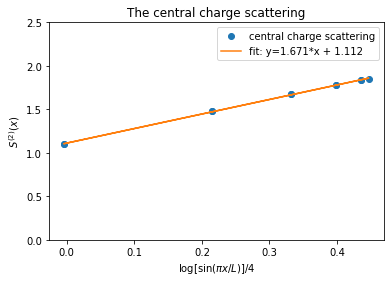

In [32]:
import matplotlib.pyplot as plt
#plot central charge
x = np.arange(1,lx)
xaxis = np.log((lx/np.pi)*np.sin(np.pi*x/lx))/3
yaxis = psi_dmrg.entanglement_entropy()
plt.plot(xaxis, yaxis, 'o', label='central charge scattering')

#fit the central charge
from scipy.optimize import curve_fit
def func(x, k, b):
    return k*x + b
popt, pcov = curve_fit(func, xaxis, yaxis)
plt.plot(xaxis, func(xaxis, *popt), label='fit: y=%5.3f*x + %5.3f' % tuple(popt))
plt.title('The central charge scattering')
plt.xlabel('$\log[\sin(\pi x/L)]/4$')
plt.ylabel('$S^{(2)}(x)$')
plt.ylim(0,2.5)
plt.legend()
plt.show()